In [1]:
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import *
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.regularizers import L1L2

from keras.callbacks import ReduceLROnPlateau

%matplotlib inline

Using TensorFlow backend.


In [2]:
dataset_path = '../mfccs/13/'
cls_list = ['blues',
            'classical',
            'country',
            'disco',
            'hiphop',
            'jazz',
            'metal',
            'pop',
            'reggae',
            'rock']

### Data loading and preparation

In [3]:
X = []
y = []

for cls in tqdm(os.listdir(dataset_path)):
    cls_path = os.path.join(dataset_path, cls)
    
    for f in os.listdir(cls_path):
        X.append(pd.read_csv(os.path.join(cls_path, f), delimiter=';', header=None).iloc[:, :-1])
        y.append(cls_list.index(cls))

100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


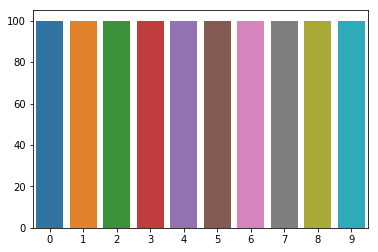

In [4]:
y_np = np.asarray(y)
v, c = np.unique(y_np, return_counts=True)
sns.barplot(v, c)

#### MFCC simplification
Each audio has 13 MFCCs per frame. We are simplifying it by computing the mean of the frames and using the resulting single vector of 13 MFCCs as the audio representation.

In [5]:
X_std = []

for idx, i in tqdm(enumerate(X)):
    a = np.mean(i, axis=0)
    b = np.std(i, axis=0)
    c = np.max(i, axis=0)
    d = np.min(i, axis=0)
    X_std.append(np.concatenate((a, b, c, d), axis=0))

1000it [00:01, 516.25it/s]


In [6]:
X_std = np.asarray(X_std)
print(X_std.shape, X_std.dtype)

(1000, 52) float64


#### Train/Val split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_std, y_np, test_size=0.33, random_state=33, stratify=y_np)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(670, 52) (330, 52) (670,) (330,)


In [8]:
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
print(y_train.shape, y_val.shape)

(670, 10) (330, 10)


In [9]:
def create_model():
    inp = Input(shape=(X_train.shape[1],))
    x = Dense(128, kernel_regularizer=L1L2(l1=0.01, l2=0.01))(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.6)(x)
    
    x = Dense(128, kernel_regularizer=L1L2(l1=0.01, l2=0.01))(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.8)(x)

    x = Dense(10)(x)
    x = Activation('softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [10]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 52)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6784      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total para

#### Normalization

In [11]:
X_train_means = X_train.mean(axis=0)
X_train_stds = X_train.std(axis=0)

print('Means:', X_train_means)
print('Stds:', X_train_stds)

Means: [-650.6297977   133.04630026   -6.57415915   34.46168699   -3.30174185
   12.07065647   -7.9906482    10.0232402    -8.30882395    7.52375389
   -6.85239181    4.18318983   -5.18664802   66.4891696    32.7371354
   28.25917492   19.27443766   16.67788105   14.86727789   14.26556059
   12.24875379   11.81604153   11.25382926   10.54845912   10.16897423
    9.94115452 -493.9756      217.54783134   79.17269577   92.97294896
   45.95522798   56.12917075   37.42352725   50.05339124   29.39388039
   45.09759522   28.51853882   38.41789504   28.65686412 -876.86428955
   15.31389407  -86.54747836  -27.15129569  -57.72754537  -37.53052442
  -53.60807119  -30.10859231  -47.66766194  -29.23773396  -41.68957149
  -29.58160331  -38.14924746]
Stds: [101.02985116  36.1597846   24.5315318   20.24361409  12.1117232
  13.29301     10.08719245  10.236978     7.8850999    7.24217957
   6.96274209   5.67676019   5.68651412  22.05998519   9.54818898
   7.92716518   4.88187836   4.34301866   3.7524263

In [12]:
X_train -= X_train_means
X_train /= X_train_stds

print('Means:', X_train.mean(axis=0))
print('Std:', X_train.std(axis=0))

Means: [-3.91063633e-15  3.09304821e-15 -1.77469979e-16  1.09680093e-15
 -1.65870634e-16 -7.98987742e-16  7.04908768e-16  9.56780260e-16
 -2.13179391e-16  1.39988560e-15  1.17683641e-15  8.07811529e-17
 -2.43669098e-16  1.79955553e-15  6.61162667e-16  2.56544371e-15
 -3.22329228e-15 -5.60911185e-16 -8.38466941e-16  3.94543436e-15
  2.92568623e-15  2.24695884e-16 -6.45752109e-15  1.33922724e-15
  3.93582347e-15 -4.44851453e-15  3.67920868e-15 -6.21062074e-16
  2.13759358e-16 -7.43518017e-16  1.55961479e-15  4.15720526e-15
 -1.74661280e-15  4.03955476e-15  2.70297880e-15  7.23799130e-16
  1.67150705e-15  4.92375626e-15 -1.96078643e-15 -1.72333126e-17
  2.25855818e-16 -7.63444034e-16 -4.32986980e-16 -2.55765558e-15
  1.10028073e-16 -1.63451342e-15  1.31304586e-15  3.19843654e-15
  1.60468653e-15  3.37242672e-15 -3.80698789e-15  1.62302800e-15]
Std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [13]:
X_val -= X_train_means
X_val /= X_train_stds

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=20, min_lr=0.00001)

In [15]:
model = create_model()
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=300, 
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr])

Train on 670 samples, validate on 330 samples
Epoch 1/300
670/670 [==============================] - 1s - loss: 10.1702 - acc: 0.1373 - val_loss: 8.5948 - val_acc: 0.2515
Epoch 2/300
670/670 [==============================] - 0s - loss: 9.2236 - acc: 0.2149 - val_loss: 7.9649 - val_acc: 0.3424
Epoch 3/300
670/670 [==============================] - 0s - loss: 8.4953 - acc: 0.2582 - val_loss: 7.4308 - val_acc: 0.3727
Epoch 4/300
670/670 [==============================] - 0s - loss: 7.9898 - acc: 0.2448 - val_loss: 6.9508 - val_acc: 0.3970
Epoch 5/300
670/670 [==============================] - 0s - loss: 7.3003 - acc: 0.3194 - val_loss: 6.5105 - val_acc: 0.4182
Epoch 6/300
670/670 [==============================] - 0s - loss: 6.8656 - acc: 0.3433 - val_loss: 6.0979 - val_acc: 0.4606
Epoch 7/300
670/670 [==============================] - 0s - loss: 6.4212 - acc: 0.3687 - val_loss: 5.7200 - val_acc: 0.4879
Epoch 8/300
670/670 [==============================] - 0s - loss: 5.9583 - acc: 0.391

670/670 [==============================] - 0s - loss: 1.6842 - acc: 0.5672 - val_loss: 1.5278 - val_acc: 0.6727
Epoch 67/300
670/670 [==============================] - 0s - loss: 1.7373 - acc: 0.5597 - val_loss: 1.5515 - val_acc: 0.6697
Epoch 68/300
670/670 [==============================] - 0s - loss: 1.6956 - acc: 0.5597 - val_loss: 1.5494 - val_acc: 0.6667
Epoch 69/300
670/670 [==============================] - 0s - loss: 1.7293 - acc: 0.5552 - val_loss: 1.5425 - val_acc: 0.6697
Epoch 70/300
670/670 [==============================] - 0s - loss: 1.6532 - acc: 0.5970 - val_loss: 1.5681 - val_acc: 0.6758
Epoch 71/300
670/670 [==============================] - 0s - loss: 1.6532 - acc: 0.6090 - val_loss: 1.5524 - val_acc: 0.6545
Epoch 72/300
670/670 [==============================] - 0s - loss: 1.6161 - acc: 0.5910 - val_loss: 1.5240 - val_acc: 0.6545
Epoch 73/300
670/670 [==============================] - 0s - loss: 1.6418 - acc: 0.5896 - val_loss: 1.5220 - val_acc: 0.6515
Epoch 74/300


670/670 [==============================] - 0s - loss: 1.3433 - acc: 0.6657 - val_loss: 1.3658 - val_acc: 0.6879
Epoch 132/300
670/670 [==============================] - 0s - loss: 1.3127 - acc: 0.6925 - val_loss: 1.3661 - val_acc: 0.6879
Epoch 133/300
670/670 [==============================] - 0s - loss: 1.3407 - acc: 0.6567 - val_loss: 1.3597 - val_acc: 0.6879
Epoch 134/300
670/670 [==============================] - 0s - loss: 1.2801 - acc: 0.6896 - val_loss: 1.3520 - val_acc: 0.6879
Epoch 135/300
670/670 [==============================] - 0s - loss: 1.3020 - acc: 0.6791 - val_loss: 1.3478 - val_acc: 0.6848
Epoch 136/300
670/670 [==============================] - 0s - loss: 1.2583 - acc: 0.6970 - val_loss: 1.3388 - val_acc: 0.6909
Epoch 137/300
670/670 [==============================] - 0s - loss: 1.3095 - acc: 0.6687 - val_loss: 1.3358 - val_acc: 0.6909
Epoch 138/300
670/670 [==============================] - 0s - loss: 1.3093 - acc: 0.6642 - val_loss: 1.3296 - val_acc: 0.6939
Epoch 

670/670 [==============================] - 0s - loss: 1.1454 - acc: 0.7015 - val_loss: 1.2151 - val_acc: 0.6788
Epoch 197/300
670/670 [==============================] - 0s - loss: 1.1444 - acc: 0.6896 - val_loss: 1.2161 - val_acc: 0.7000
Epoch 198/300
670/670 [==============================] - 0s - loss: 1.1096 - acc: 0.7209 - val_loss: 1.2218 - val_acc: 0.6939
Epoch 199/300
670/670 [==============================] - 0s - loss: 1.1240 - acc: 0.7224 - val_loss: 1.2181 - val_acc: 0.6909
Epoch 200/300
670/670 [==============================] - 0s - loss: 1.1378 - acc: 0.6970 - val_loss: 1.2079 - val_acc: 0.6939
Epoch 201/300
670/670 [==============================] - 0s - loss: 1.1742 - acc: 0.6806 - val_loss: 1.2065 - val_acc: 0.7061
Epoch 202/300
670/670 [==============================] - 0s - loss: 1.1335 - acc: 0.6881 - val_loss: 1.2128 - val_acc: 0.7030
Epoch 203/300
670/670 [==============================] - 0s - loss: 1.0766 - acc: 0.7269 - val_loss: 1.2130 - val_acc: 0.7121
Epoch 

670/670 [==============================] - 0s - loss: 1.0904 - acc: 0.7090 - val_loss: 1.1729 - val_acc: 0.7000
Epoch 262/300
670/670 [==============================] - 0s - loss: 1.0758 - acc: 0.7149 - val_loss: 1.1696 - val_acc: 0.6909
Epoch 263/300
670/670 [==============================] - 0s - loss: 1.0826 - acc: 0.7060 - val_loss: 1.1666 - val_acc: 0.6970
Epoch 264/300
670/670 [==============================] - 0s - loss: 1.0846 - acc: 0.7179 - val_loss: 1.1668 - val_acc: 0.7091
Epoch 265/300
670/670 [==============================] - 0s - loss: 1.0989 - acc: 0.6896 - val_loss: 1.1672 - val_acc: 0.7061
Epoch 266/300
670/670 [==============================] - 0s - loss: 1.0820 - acc: 0.6940 - val_loss: 1.1725 - val_acc: 0.7030
Epoch 267/300
670/670 [==============================] - 0s - loss: 1.0561 - acc: 0.7194 - val_loss: 1.1733 - val_acc: 0.7061
Epoch 268/300
670/670 [==============================] - 0s - loss: 1.0701 - acc: 0.7045 - val_loss: 1.1707 - val_acc: 0.7000
Epoch 

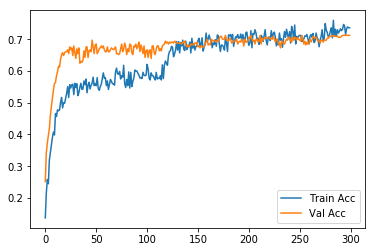

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train Acc', 'Val Acc'])

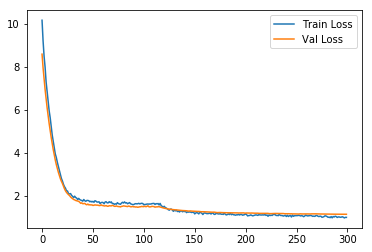

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

In [18]:
y_train_pred = model.predict(X_train)
y_train_pred_max = np.argmax(y_train_pred, axis=1)
y_train_max = np.argmax(y_train, axis=1)

print('Train')
print(classification_report(y_train_max, y_train_pred_max))

Train
              precision    recall  f1-score   support

           0       0.88      0.87      0.87        67
           1       1.00      0.99      0.99        67
           2       0.93      0.84      0.88        67
           3       0.87      0.88      0.87        67
           4       0.89      0.93      0.91        67
           5       0.94      0.99      0.96        67
           6       0.89      0.99      0.94        67
           7       0.96      0.97      0.96        67
           8       0.84      0.84      0.84        67
           9       0.75      0.69      0.72        67

   micro avg       0.90      0.90      0.90       670
   macro avg       0.89      0.90      0.89       670
weighted avg       0.89      0.90      0.89       670



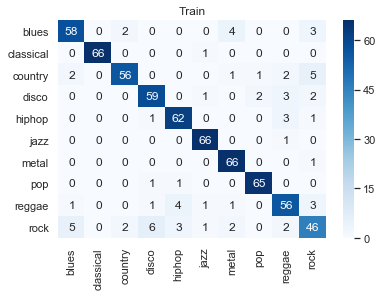

In [19]:
cm = confusion_matrix(y_train_max, y_train_pred_max)
sns.set()
plt.figure()
plt.title('Train')
sns.heatmap(cm, annot=True, yticklabels=cls_list, xticklabels=cls_list, cmap='Blues')

In [20]:
y_pred = model.predict(X_val)
y_pred_max = np.argmax(y_pred, axis=1)
y_max = np.argmax(y_val, axis=1)

print('Val')
print(classification_report(y_max, y_pred_max))

Val
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        33
           1       0.88      0.91      0.90        33
           2       0.66      0.76      0.70        33
           3       0.61      0.52      0.56        33
           4       0.59      0.61      0.60        33
           5       0.80      0.85      0.82        33
           6       0.76      0.85      0.80        33
           7       0.76      0.76      0.76        33
           8       0.72      0.70      0.71        33
           9       0.53      0.52      0.52        33

   micro avg       0.71      0.71      0.71       330
   macro avg       0.71      0.71      0.71       330
weighted avg       0.71      0.71      0.71       330



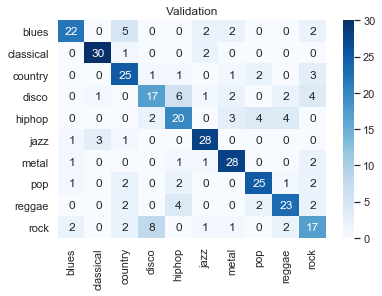

In [21]:
cm = confusion_matrix(y_max, y_pred_max)
sns.set()
plt.figure()
plt.title('Validation')
sns.heatmap(cm, annot=True, yticklabels=cls_list, xticklabels=cls_list, cmap='Blues')